In [2]:
#from helper import differential_equation_loss, optimizer_function_factory
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers


In [3]:
# el data set
import tensorflow as tf
# Ruta del archivo TFRecord que deseas cargar
input_path = "dataset.tfrecord"


# Función para parsear un ejemplo TFRecord
def parse_dataset(example_proto):
    feature_description = {
        'x': tf.io.FixedLenFeature([3], tf.float32),
        'v': tf.io.FixedLenFeature([3], tf.float32)
    }
    dataset = tf.io.parse_single_example(example_proto, feature_description)
    return dataset['x'], dataset['v']

# Cargar el dataset desde el archivo TFRecord
dataset = tf.data.TFRecordDataset(input_path)
dataset = dataset.map(parse_dataset)


def head_dataset(dataset):
    # Ahora puedes iterar sobre el dataset para leer los datos
    print_n = 5
    for data in dataset:
        print(data)
        print_n -= 1
        if print_n < 0:
            break

head_dataset(dataset)

(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([3.9167395, 3.805452 , 3.721134 ], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.3183789 , -0.934036  , -0.75950456], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([3.805452 , 3.721134 , 3.6490405], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.934036  , -0.75950456, -0.67820454], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([3.721134 , 3.6490405, 3.582606 ], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.75950456, -0.67820454, -0.64235467], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([3.6490405, 3.582606 , 3.5185351], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.67820454, -0.64235467, -0.6291701 ], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([3.582606 , 3.5185351, 3.4551263], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy

In [4]:
# Define el tamaño del lote (batch)
batch_size = 32

# Mezcla los datos y crea lotes
dataset = dataset.shuffle(buffer_size=1000)  # Opcional: si deseas mezclar los datos
dataset = dataset.batch(batch_size)

In [5]:
def lendataset(dataset):
    size = 0
    for batch_x, batch_v in dataset:
        # Realiza operaciones con el lote de datos
        size += batch_x.shape[0]
    return size
    
lendataset(dataset)

49000

## El modelo
El modelo tiene una sola entrada y una sola salida; quiere decir que es necesario conocer $x_k$ para entonces predecir $x_{k+1}$, el modelo se encarga de predecir el siguiente paso temporal,
Este hecho permite calcular el momentum a partir del modelo; por tanto hay varios constrains a tener en cuenta para optimizar esto:

- $$p = \frac{dx}{dt} = \frac{x_{k+1} - x_{k-1}}{2h}$$

- $$\frac{d^2x}{dt^2} = \frac{x_{k+1} - 2 x_k + x_{k-1}}{h^2}$$

## leer el dataset

In [6]:
# Supongamos que tienes 1000 elementos en tu dataset
total_size = lendataset(dataset)
# Supongamos que tienes un tamaño de lote (batch_size) definido previamente
batch_size = 32

# Define el tamaño de los conjuntos de entrenamiento, validación y prueba
train_p = 0.8
valid_p = 0.1
test_p = 1 - train_p - valid_p

train_size = int( total_size * train_p )
valid_size = int( total_size * valid_p )
test_size = int( total_size * test_p )

# Divide el dataset en tres conjuntos
train_dataset = dataset.take(train_size // batch_size)
valid_dataset = dataset.skip(train_size // batch_size).take(valid_size // batch_size)

test_dataset = dataset.skip(
    train_size // batch_size + valid_size // batch_size).take(test_size // batch_size)


print("train size", lendataset(train_dataset))
print("valid size", lendataset(valid_dataset))
print("test size", lendataset(test_dataset))


train size 39200
valid size 4896
test size 4896


In [7]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [8]:
head_dataset(train_dataset)

(<tf.Tensor: shape=(32, 3), dtype=float32, numpy=
array([[ 0.8902102 ,  1.0394702 ,  1.177661  ],
       [-2.5611386 , -2.4803348 , -2.3957515 ],
       [ 0.7023858 ,  0.9403398 ,  1.1704621 ],
       [-1.8439734 , -1.7719345 , -1.6901397 ],
       [-1.795076  , -1.8986237 , -1.9733801 ],
       [-2.5676506 , -2.510848  , -2.44491   ],
       [ 1.6127248 ,  1.5082314 ,  1.3953254 ],
       [-0.05889327,  0.1527915 ,  0.37342802],
       [-1.4789399 , -1.3675904 , -1.2473671 ],
       [ 0.743113  ,  0.59760565,  0.44066027],
       [ 2.078734  ,  2.0633154 ,  2.0309043 ],
       [ 2.0752487 ,  2.0577796 ,  2.023416  ],
       [ 1.6436958 ,  1.5421443 ,  1.432203  ],
       [ 1.3141071 ,  1.220266  ,  1.1163229 ],
       [ 0.87771595,  0.743113  ,  0.59760565],
       [ 1.5193801 ,  1.6731627 ,  1.797557  ],
       [-0.287925  , -0.5126584 , -0.74066275],
       [-1.8974319 , -1.9661478 , -2.0071504 ],
       [ 1.9913605 ,  1.9523164 ,  1.8996731 ],
       [ 1.3365942 ,  1.215235  ,  1.0

In [9]:
# Convierte las listas de tuplas en tensores
def list_of_tuples_to_tensors(dataset_list):
    x_list, v_list = zip(*dataset_list)
    x_tensor = tf.convert_to_tensor(x_list, dtype=tf.float32)
    v_tensor = tf.convert_to_tensor(v_list, dtype=tf.float32)
    return x_tensor, v_tensor

train_dataset = list_of_tuples_to_tensors(train_dataset)
valid_dataset = list_of_tuples_to_tensors(valid_dataset)
test_dataset = list_of_tuples_to_tensors(test_dataset)

In [14]:
xk_train = train_dataset[0][:, :, 0]
dxk_dt_train = train_dataset[1][:, :,0]

xkp1_train = train_dataset[0][:, :,1]
xkp2_train = train_dataset[0][:, :,2]
dxdt_train = train_dataset[1][:, :,1]

Z_train =tf.stack([xk_train, dxk_dt_train], axis=-1)
Z_train.shape

Z_target = tf.stack([xkp1_train, xkp2_train, dxdt_train], axis=-1)
Z_target.shape

TensorShape([1225, 32, 3])

In [15]:
xk_valid = valid_dataset[0][:, :, 0]
dxk_dt_valid = valid_dataset[1][:, :,0]

xkp1_valid = valid_dataset[0][:, :,1]
xkp2_valid = valid_dataset[0][:, :,2]
dxdt_valid = valid_dataset[1][:, :,1]

Z_valid =tf.stack([xk_valid, dxk_dt_valid], axis=-1)
Z_valid.shape

Z_target_valid = tf.stack([xkp1_valid, xkp2_valid, dxdt_valid], axis=-1)
Z_target_valid.shape


TensorShape([153, 32, 3])

In [17]:
xk_test = test_dataset[0][:, :, 0]
dxk_dt_test = test_dataset[1][:, :,0]

xkp1_test = test_dataset[0][:, :,1]
xkp2_test = test_dataset[0][:, :,2]
dxdt_test = test_dataset[1][:, :,1]

Z_test =tf.stack([xk_test, dxk_dt_test], axis=-1)
Z_test.shape

Z_target_test = tf.stack([xkp1_test, xkp2_test, dxdt_test], axis=-1)
Z_target_test.shape

TensorShape([153, 32, 3])

# Model

In [18]:
class ResidualBlock(layers.Layer):
    def __init__(self, n_layers=4, n_neuron=64, activation='tanh', **kwargs):
        super().__init__(**kwargs)
        self.inputlayer = layers.Dense(1, activation=None)
        self.hidden = [
            layers.Dense(n_neuron, activation=activation,
                kernel_initializer="he_normal")
            for _ in range(n_layers)
        ]
        self.outputlayer = layers.Dense(1, activation=None)
    
    def call(self, inputs):
        Z = self.inputlayer(inputs)
        for layer in self.hidden:
            Z = layer(Z)
        return self.outputlayer(Z) + self.inputlayer(inputs)

In [19]:
resblock =  ResidualBlock(4, 64, 'tanh')
resblock(xk_train)

<tf.Tensor: shape=(1225, 1), dtype=float32, numpy=
array([[-5.387918 ],
       [ 0.6336356],
       [-2.4376612],
       ...,
       [ 2.6457486],
       [ 6.414005 ],
       [ 7.533992 ]], dtype=float32)>

In [20]:
class ResidualRegressor(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        #self.flatten = layers.Flatten()  # Aplana los datos
        self.input_layer = layers.Dense(2, activation=None)
        self.resblock = ResidualBlock(4, 64, 'tanh')
    

    def call(self, inputs):

        # input (x_k, p_k)
        Z = self.input_layer(inputs)

        xk = Z[:,:,0]
        pk = Z[:,:,1]
        # calcula x_k+1
        xkp1 = self.resblock(xk) + pk/2
        # # calcula x_k+2
        xkp2 = self.resblock(xkp1) + pk/2
        

        # derivada centrada
        # f' = (f(x+h) - f(x-h) )/ 2h + O(h^2)
        # asumimos h=1
        dxdt = ( xkp2 - xk )/2

        return tf.stack([xkp1, xkp2, dxdt], axis=-1)


model = ResidualRegressor()
# ... model build

In [21]:
# Compila el modelo (puedes ajustar el optimizador y la función de pérdida según tus necesidades)
model.compile(optimizer='adam', loss='mse')

# Entrena el modelo
history = model.fit(Z_train, Z_target, epochs=50, validation_split=0.1)


Epoch 1/50
35/35 [==============================] - 2s 13ms/step - loss: 3.6341 - val_loss: 3.1024
Epoch 2/50
35/35 [==============================] - 0s 5ms/step - loss: 3.1526 - val_loss: 2.9530
Epoch 3/50
35/35 [==============================] - 0s 5ms/step - loss: 3.0096 - val_loss: 2.8327
Epoch 4/50
 1/35 [..............................] - ETA: 0s - loss: 2.8501

KeyboardInterrupt: 

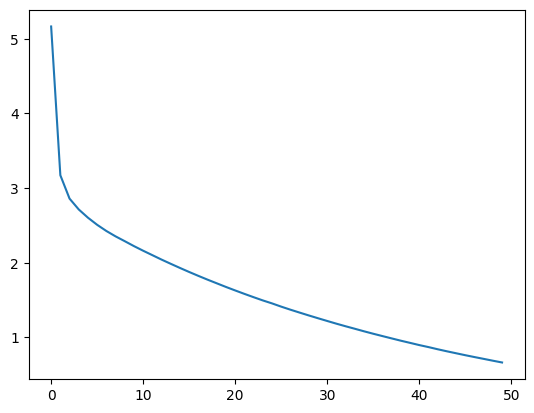

In [173]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])


In [174]:
head_dataset(train_dataset)

tf.Tensor(
[[[-1.18310821e+00 -1.38308847e+00 -1.56088507e+00]
  [ 2.80720979e-01  8.40639547e-02 -1.24016054e-01]
  [-7.46678634e-05  2.27418467e-01  4.62978810e-01]
  ...
  [-1.25822902e+00 -1.12515056e+00 -9.82426465e-01]
  [-1.59050012e+00 -1.48945868e+00 -1.37970924e+00]
  [-2.07178426e+00 -2.07377982e+00 -2.05593204e+00]]

 [[ 2.01470375e+00  1.99136055e+00  1.95231640e+00]
  [ 1.43132639e+00  1.31551242e+00  1.19076920e+00]
  [ 1.05018365e+00  1.27217758e+00  1.47426498e+00]
  ...
  [-4.37876105e-01 -6.65072203e-01 -8.92044902e-01]
  [ 1.08455312e+00  9.43797827e-01  7.92372465e-01]
  [ 2.81536674e+00  2.84546256e+00  2.84199762e+00]]

 [[-4.04996157e-01 -2.15171486e-01 -1.39176268e-02]
  [ 1.82094347e+00  1.73675585e+00  1.64369583e+00]
  [-1.85426235e+00 -1.93711412e+00 -1.99115407e+00]
  ...
  [ 1.85262012e+00  1.93570757e+00  1.98974276e+00]
  [-1.98200488e+00 -1.93185747e+00 -1.87003064e+00]
  [-1.06246746e+00 -9.01911497e-01 -7.30688632e-01]]

 ...

 [[ 1.10912371e+00  1.3

In [72]:

# Evalúa el modelo en el conjunto de validación
validation_loss = model.evaluate(xk_valid, (xkp1_valid, xkp2_valid, dxdt_valid))
print("Validation Loss:", validation_loss)


5/5 [==============================] - 0s 5ms/step - loss: 7.8047 - output_1_loss: 2.9263 - output_2_loss: 2.8727 - output_3_loss: 2.0057
Validation Loss: [7.804656982421875, 2.9263100624084473, 2.872685432434082, 2.005661725997925]
